In [21]:
# Installs
!pip install imageai
!pip install tensorflow
!pip install pickle-mixin
!pip install mediapipe
!pip install scikit-learn==1.0
# !python -m pip uninstall matplotlib
!pip install matplotlib==3.1.3
!pip install tensorflow-object-detection-api
!pip install dataframe-image
!pip install python-docx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached matplotlib-3.3.2-cp37-cp37m-manylinux1_x86_64.whl (11.6 MB)
  Using cached numpy-1.19.3-cp37-cp37m-manylinux2010_x86_64.whl (14.9 MB)
  Using cached Keras-2.4.3-py2.py3-none-any.whl (36 kB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.3
    Uninstalling matplotlib-3.5.3:
      Successfully uninstalled matplotlib-3.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray-einstats 0.2.2 requires numpy>=1.21, but you ha

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached keras-2.9.0-py2.py3-none-any.whl (1.6 MB)
  Using cached numpy-1.21.6-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.7 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.3
    Uninstalling numpy-1.19.3:
      Successfully uninstalled numpy-1.19.3
  Attempting uninstall: keras
    Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
plotnine 0.8.0 requires scipy>=1.5.0, but you have scipy 1.4.1 which is incompatible.
jaxlib 0.3.22+cuda11.cudnn805 requires scipy>=1.5, but you have scipy 1.4.1 which is incompatible.
jax 0.3.23 requires scipy>=1.5, but you have scipy 1.4.1 which is incompatible.
imageai 2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Found existing installation: matplotlib 3.3.2
Uninstalling matplotlib-3.3.2:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.3.2-py3.7-nspkg.pth
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.3.2.dist-info/*
    /usr/local/lib/python3.7/dist-packages/matplotlib/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid1/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axisartist/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/tests/*
    /usr/local/lib/python3.7/dist-packages/pylab.py
Proceed (y/n)? y
 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Importing Module
!pip install pydrive                             # Package to use Google Drive API - not installed in Colab VM by default
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive

from google.colab import auth                    # Other necessary packages
from oauth2client.client import GoogleCredentials

auth.authenticate_user()                         # Follow prompt in the authorization process
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()

drive = GoogleDrive(gauth)
# https://drive.google.com/file/d/1UXpKfXMFVgNYDH5j3K-RZkWLTbGLKblv/view?usp=sharing
your_module = drive.CreateFile({"id": "1UXpKfXMFVgNYDH5j3K-RZkWLTbGLKblv"})   # "your_module_file_id" is the part after "id=" in the shareable link
your_module.GetContentFile("PoseModule.py")          # Save the .py module file to Colab VM

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
# Imports
from imageai.Detection import ObjectDetection
import os
import pickle
from sklearn import preprocessing
import numpy as np
from google.colab.patches import cv2_imshow
import cv2
from skimage.color import rgb2gray
from skimage.transform import resize
import matplotlib.pyplot as plt
import math
import PoseModule as pm
import pandas as pd
import csv
from object_detection.utils import visualization_utils as vis_utils
from PyPDF2 import PdfFileWriter
from PIL import Image
import matplotlib.pyplot as plt
# import pandas as pd
# from pandas.table.plotting import table
from pandas.plotting import table 
execution_path = "/content/drive/MyDrive/Colab Notebooks"
%matplotlib inline
import dataframe_image as dfi
import docx
from docx.shared import Inches

In [16]:
# Pose Classification Module
def multiPoseClassifier(inputVideo):
  detector = ObjectDetection()
  detector.setModelTypeAsRetinaNet()
  
  detector.setModelPath( os.path.join(execution_path , "resnet50_coco_best_v2.1.0.h5"))
  detector.loadModel()
  poseDetector = pm.PoseDetector()
  # poseDetector.poseClassifier()
  # loaded_model = pickle.load(open(os.path.join(execution_path , 'knn_r_pca_pipe.sav'), 'rb'))
  loaded_model = pickle.load(open(os.path.join(execution_path , 'rf_pipe_pickle.sav'), 'rb'))
  custom_objects = detector.CustomObjects(person=True)
  # folder_path = '/content/drive/MyDrive/Colab Notebooks/Thesis-object-detection/frames'

  output = []
  count = 0
  one_frame_each = 100
  folder_name = "test2"
  videofile = os.path.join(execution_path,"test2.mov")
  vidcap = cv2.VideoCapture(videofile)

  success = True
  while success:
      if (count % one_frame_each == 0):                                   # checks frame number and keeps one_frame_each          
          success,image = vidcap.read() 
          print(count)
          # image = cv2.imread(os.path.join(folder_path , filename))
          file_name = 'frame' + str(count)+ '.png'
          cv2.imwrite(os.path.join(execution_path, folder_name, file_name), image)
          op_img = "temp.jpg"                                # reads next frame           
          detections = detector.detectCustomObjectsFromImage(custom_objects=custom_objects, input_image= os.path.join(execution_path, folder_name, file_name), output_image_path=os.path.join(execution_path , op_img), minimum_percentage_probability=30)
          person_count = 0
          img = Image.open(os.path.join(execution_path , folder_name, file_name))
          for eachObject in detections:
            person_count += 1
            if eachObject["percentage_probability"] > 65:
              boxPoints = eachObject["box_points"]
              x1, y1, x2, y2 = boxPoints
              top_left_x = min([x1,x2])
              top_left_y = min([y1,y2])
              bot_right_x = max([x1,x2])
              bot_right_y = max([y1,y2])
              cropped = image[top_left_y:bot_right_y+1, top_left_x:bot_right_x+1]
              # crop,className = poseDetector.poseClassifier(cropped, loaded_model)
              crop,className,confidence = poseDetector.poseClassifier(cropped,loaded_model)
              if confidence is not None:                
                confidence = max(confidence[0]) * 100
                confidence = round(confidence,2)               
              row = [count, person_count, eachObject["percentage_probability"], className,confidence]
              output.append(row)                
              op_str = ""
              op_str += str(className) + ":" + str(confidence) + "%"
          
              # print(className, confidence)
              vis_utils.draw_bounding_box_on_image(
                          img, top_left_y, top_left_x, bot_right_y, bot_right_x,
                          color='cyan',thickness=5,
                          # display_str_list=[str(className),":",str(confidence),"%"],
                          display_str_list=[op_str],
                          use_normalized_coordinates=False
                  )    
              # op = filename
              rgb_im = img.convert('RGB')
              rgb_im.save(os.path.join(execution_path, folder_name, file_name))   
      else:
        success,image = vidcap.read()
        # print("err")
          # success,image = vidcap.read()                                 # reads next frame    
      count += 1

  print(count)
  return output

In [12]:
# Data Aggregation
def dataAnalyse(df):  
  df = df.dropna()  
  mapping = {
    "Hand_on_chin" : "Intermediate1",
    "Hand_on_head" : "Intermediate1",
    "Hand_raised" : "Attentive",
    "Hands_Crossed" : "Attentive",
    "Leaning_Forward" : "Intermediate2",
    "Looking_down" : "Intermediate2",
    "Looking_to_the_side" : "Inattentive",
    "Sitting_Straight" : "Attentive",
    "Sleeping" : "Inattentive",
    "Taking_Notes" : "Attentive"
  }
  df['Classification'] = df['Pose'].map(mapping) 

  # Classification percentage dataframe
  class_data = pd.DataFrame(df['Classification'].value_counts(normalize=True) * 100)
  dfi.export(class_data, os.path.join(execution_path,'ClassTable.png'),table_conversion = 'matplotlib')
  # Bar plot
  ax = class_data.plot.barh(rot=0, figsize=(9, 7)).get_figure()
  ax.savefig(os.path.join(execution_path,'classBar.png'))  
  # Pie Chart
  plot_image = class_data.plot.pie(subplots=True, figsize=(7, 7), autopct='%1.0f%%',legend = False)[0].get_figure()   
  plot_image.savefig(os.path.join(execution_path,'classPie.png'))
  
  # Pose percentage dataframe
  pose_data = pd.DataFrame(df['Pose'].value_counts(normalize=True) * 100)
  dfi.export(pose_data, os.path.join(execution_path,'PoseTable.png'),table_conversion = 'matplotlib')
  # Bar plot
  ax_p = pose_data.plot.barh(rot=0, figsize=(12, 9)).get_figure() 
  ax_p.savefig(os.path.join(execution_path,'poseBar.png'))  
  # Pie Chart
  plot_image_p = pose_data.plot.pie(subplots=True, figsize=(9, 9), autopct='%1.0f%%',legend = False)[0].get_figure()
  plot_image_p.savefig(os.path.join(execution_path,'posePie.png')) 
  

In [13]:
def createDoc():
  
  # Create an instance of a word document
  doc = docx.Document()
    
  # Add a Title to the document
  doc.add_heading('Attentiveness Feedback Report', 0)
    
  # Image in its native size
  doc.add_heading('Classification Pie Chart', 3)
  doc.add_picture(os.path.join(execution_path,'classPie.png'), width=Inches(4), height=Inches(4))

  doc.add_heading('Classification Bar Chart', 3)
  doc.add_picture(os.path.join(execution_path,'classBar.png'), width=Inches(4), height=Inches(4))

  doc.add_heading('Classification table', 3)
  doc.add_picture(os.path.join(execution_path,'ClassTable.png'), width=Inches(2), height=Inches(2))

  doc.add_heading('Posture Pie Chart', 3)
  doc.add_picture(os.path.join(execution_path,'posePie.png'), width=Inches(4), height=Inches(4))

  doc.add_heading('Posture Bar Chart', 3)
  doc.add_picture(os.path.join(execution_path,'poseBar.png'), width=Inches(4), height=Inches(4))

  doc.add_heading('Posture table', 3)
  doc.add_picture(os.path.join(execution_path,'PoseTable.png'), width=Inches(4), height=Inches(4))
    
  # Now save the document to a location
  doc.save(os.path.join(execution_path,'report.docx'))


In [14]:
def createCSV(output):
  with open(os.path.join(execution_path , 'op_CSV.csv'), mode='w') as classification_file:
      classification_writer = csv.writer(classification_file, delimiter=',', quoting=csv.QUOTE_MINIMAL)
      classification_writer.writerow(["Frame No.", "Person No.", "Person Confidence", "Pose","Pose Confidence"])
      for row in output:
        classification_writer.writerow(row)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


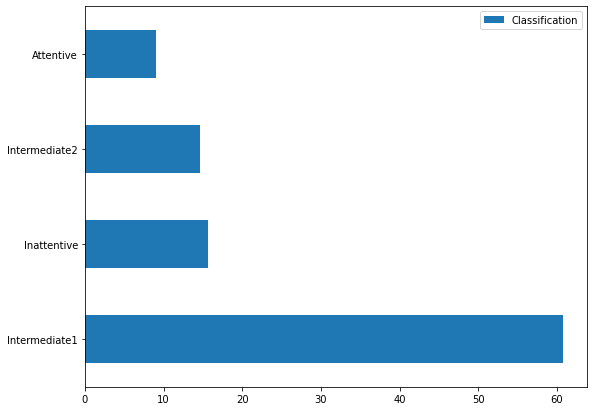

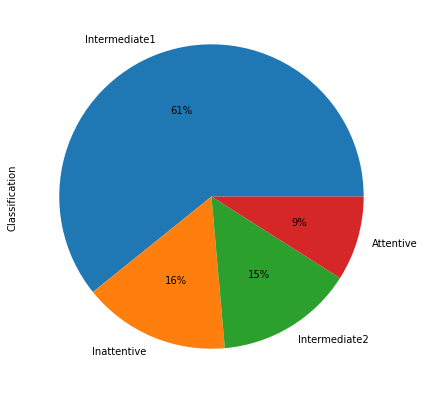

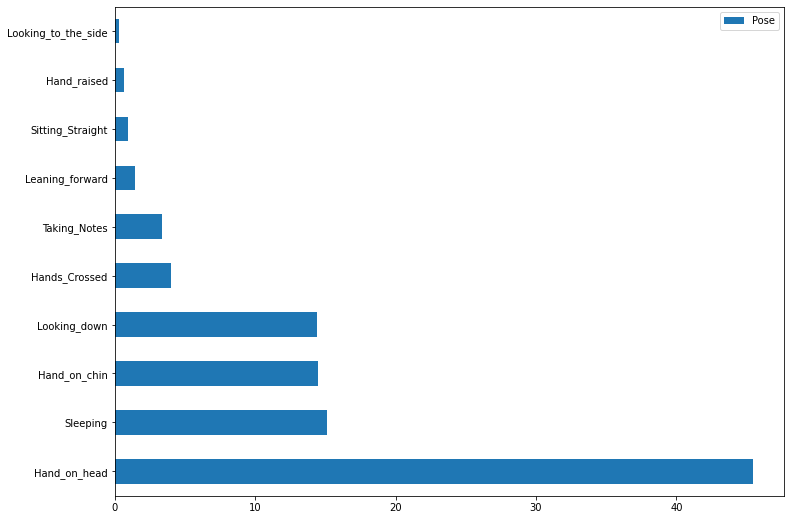

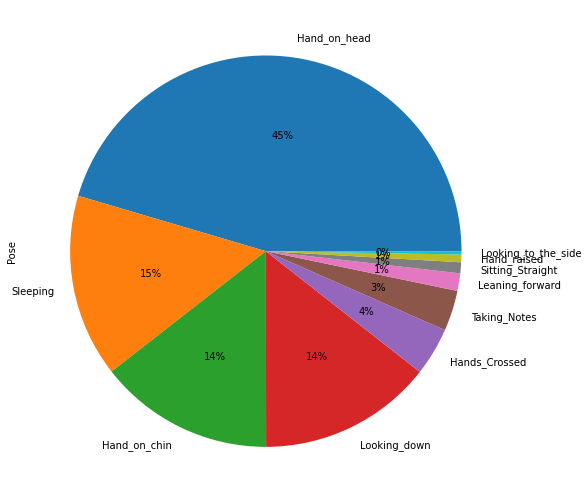

In [22]:
# Main
inp_video = "test2.mov"
output = multiPoseClassifier(inp_video)
createCSV(output)
df = pd.DataFrame.from_records(output, columns = ["Frame No.", "Person No.", "Person Confidence", "Pose","Pose Confidence"])
dataAnalyse(df)
createDoc()



In [ ]:
# import pandas as pd
# import os
# execution_path = "/content/drive/MyDrive/Colab Notebooks"
# op = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/res.csv')
# # ct, pt = dataAnalyse(op)
# pie_class , bar_class, pie_pose, bar_pose, ct, pt = dataAnalyse(op)
# # type(pie_class)